In [1]:
from goatools.associations import read_ncbi_gene2go
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as MOUSE_GENEID2NT
import mygene

In [2]:
from typing import Callable, Any
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable, Any, Union, Dict
import umap
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-13 14:43:21.042593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 14:43:21.897902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
from sklearn.model_selection import train_test_split

In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}

adata = anndata.read_h5ad("data/fede_count.h5ad")
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
adata.obs.index = adata.obs.index.astype('str')

anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
anno_df = anno_df.set_index('cell_id')[['class_name']]
anno_df.index = anno_df.index.astype('str')

In [3]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)
adata.obs.index = adata.obs.index.astype('str')

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])
anno_df = anno_df.set_index('cell_id')[['class_name']]
anno_df.index = anno_df.index.astype('str')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata.obs['class_name'] = anno_df['class_name']

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[(adata.obs.pct_counts_mt < 5), :]
#adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
#sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)
#sc.pp.scale(adata)

In [19]:
def LN(x: torch.Tensor, eps: float = 1e-5) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    mu = x.mean(dim=-1, keepdim=True)
    x = x - mu
    std = x.std(dim=-1, keepdim=True)
    x = x / (std + eps)
    return x, mu, std

class TiedTranspose(nn.Module):
    def __init__(self, linear: nn.Linear):
        super().__init__()
        self.linear = linear

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert self.linear.bias is None
        return F.linear(x, self.linear.weight.t(), None)

    @property
    def weight(self) -> torch.Tensor:
        return self.linear.weight.t()

    @property
    def bias(self) -> torch.Tensor:
        return self.linear.bias

class TopK(nn.Module):
    def __init__(self, k: int, postact_fn: Callable = nn.ReLU()) -> None:
        super().__init__()
        self.k = k
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        state_dict = super().state_dict(destination, prefix, keep_vars)
        state_dict.update({prefix + "k": self.k, prefix + "postact_fn": self.postact_fn.__class__.__name__})
        return state_dict

    @classmethod
    def from_state_dict(cls, state_dict: Dict[str, torch.Tensor], strict: bool = True) -> "TopK":
        k = state_dict["k"]
        postact_fn = ACTIVATIONS_CLASSES[state_dict["postact_fn"]]()
        return cls(k=k, postact_fn=postact_fn)

ACTIVATIONS_CLASSES = {
    "ReLU": nn.ReLU,
    "Identity": nn.Identity,
    "TopK": TopK,
}

class Autoencoder(nn.Module):
    """Sparse autoencoder

    Implements:
        latents = activation(encoder(x - pre_bias) + latent_bias)
        recons = decoder(latents) + pre_bias
    """

    def __init__(
        self, n_latents: int, n_inputs: int, activation: Callable = nn.ReLU(), tied: bool = False,
        normalize: bool = False
    ) -> None:
        """
        :param n_latents: dimension of the autoencoder latent
        :param n_inputs: dimensionality of the original data (e.g residual stream, number of MLP hidden units)
        :param activation: activation function
        :param tied: whether to tie the encoder and decoder weights
        """
        super().__init__()

        self.pre_bias = nn.Parameter(torch.zeros(n_inputs))
        self.encoder = nn.Linear(n_inputs, n_latents, bias=False)
        self.latent_bias = nn.Parameter(torch.zeros(n_latents))
        self.activation = activation
        if tied:
            self.decoder = TiedTranspose(self.encoder)
        else:
            self.decoder = nn.Linear(n_latents, n_inputs, bias=False)
        self.normalize = normalize

        self.stats_last_nonzero: torch.Tensor
        self.latents_activation_frequency: torch.Tensor
        self.latents_mean_square: torch.Tensor
        self.register_buffer("stats_last_nonzero", torch.zeros(n_latents, dtype=torch.long))
        self.register_buffer("latents_activation_frequency", torch.ones(n_latents, dtype=torch.float))
        self.register_buffer("latents_mean_square", torch.zeros(n_latents, dtype=torch.float))

    def encode_pre_act(self, x: torch.Tensor, latent_slice: slice = slice(None)) -> torch.Tensor:
        """
        :param x: input data (shape: [batch, n_inputs])
        :param latent_slice: slice of latents to compute
            Example: latent_slice = slice(0, 10) to compute only the first 10 latents.
        :return: autoencoder latents before activation (shape: [batch, n_latents])
        """
        x = x - self.pre_bias
        latents_pre_act = F.linear(
            x, self.encoder.weight[latent_slice], self.latent_bias[latent_slice]
        )
        return latents_pre_act

    def preprocess(self, x: torch.Tensor) -> tuple[torch.Tensor, Dict[str, Any]]:
        if not self.normalize:
            return x, dict()
        x, mu, std = LN(x)
        return x, dict(mu=mu, std=std)

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, Dict[str, Any]]:
        """
        :param x: input data (shape: [batch, n_inputs])
        :return: autoencoder latents (shape: [batch, n_latents])
        """
        x, info = self.preprocess(x)
        return self.activation(self.encode_pre_act(x)), info

    def decode(self, latents: torch.Tensor, info: Union[Dict[str, Any], None] = None) -> torch.Tensor:
        """
        :param latents: autoencoder latents (shape: [batch, n_latents])
        :return: reconstructed data (shape: [batch, n_inputs])
        """
        ret = self.decoder(latents) + self.pre_bias
        if self.normalize:
            assert info is not None
            ret = ret * info["std"] + info["mu"]
        return ret

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        :param x: input data (shape: [batch, n_inputs])
        :return:  autoencoder latents pre activation (shape: [batch, n_latents])
                  autoencoder latents (shape: [batch, n_latents])
                  reconstructed data (shape: [batch, n_inputs])
        """
        x, info = self.preprocess(x)
        latents_pre_act = self.encode_pre_act(x)
        latents = self.activation(latents_pre_act)
        recons = self.decode(latents, info)

        # set all indices of self.stats_last_nonzero where (latents != 0) to 0
        self.stats_last_nonzero *= (latents == 0).all(dim=0).long()
        self.stats_last_nonzero += 1

        return latents_pre_act, latents, recons

    @classmethod
    def from_state_dict(cls, state_dict: Dict[str, torch.Tensor], strict: bool = True) -> "Autoencoder":
        n_latents, d_model = state_dict["encoder.weight"].shape

        # Retrieve activation
        activation_class_name = state_dict.pop("activation", "ReLU")
        activation_class = ACTIVATIONS_CLASSES.get(activation_class_name, nn.ReLU)
        normalize = activation_class_name == "TopK"  # NOTE: hacky way to determine if normalization is enabled
        activation_state_dict = state_dict.pop("activation_state_dict", {})
        if hasattr(activation_class, "from_state_dict"):
            activation = activation_class.from_state_dict(
                activation_state_dict, strict=strict
            )
        else:
            activation = activation_class()
            if hasattr(activation, "load_state_dict"):
                activation.load_state_dict(activation_state_dict, strict=strict)

        autoencoder = cls(n_latents, d_model, activation=activation, normalize=normalize)
        # Load remaining state dict
        autoencoder.load_state_dict(state_dict, strict=strict)
        return autoencoder

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        sd = super().state_dict(destination, prefix, keep_vars)
        sd[prefix + "activation"] = self.activation.__class__.__name__
        if hasattr(self.activation, "state_dict"):
            sd[prefix + "activation_state_dict"] = self.activation.state_dict()
        return sd

In [58]:
def save_model(autoencoder: nn.Module, path: str) -> None:
    """
    Saves the autoencoder model state to the specified path.

    :param autoencoder: The trained autoencoder model
    :param path: The file path to save the model state
    """
    state = {
        'model_state': autoencoder.state_dict()
    }
    torch.save(state, path)
    print(f"Model state saved to {path}")

def load_model(autoencoder: nn.Module, path: str) -> None:
    """
    Loads the autoencoder model state from the specified path.

    :param autoencoder: The autoencoder model instance
    :param path: The file path from which to load the model state
    """
    state = torch.load(path)
    model_state = state['model_state']

    # Handle activation state dict if it exists
    if 'activation_state_dict' in model_state:
        activation_state_dict = model_state.pop('activation_state_dict')
        if hasattr(autoencoder.activation, 'load_state_dict'):
            autoencoder.activation.load_state_dict(activation_state_dict)

    autoencoder.load_state_dict(model_state)
    print(f"Model state loaded from {path}")

In [49]:
# Define a custom dataset class for AnnData
class AnnDataDataset(Dataset):
    def __init__(self, adata):
        self.adata = adata

    def __len__(self):
        return self.adata.shape[0]

    def __getitem__(self, idx):
        # Convert data to a tensor and ensure the label is a compatible type
        x = torch.tensor(self.adata.X[idx].toarray(), dtype=torch.float32)
        return x

In [50]:
train_indices, test_indices = train_test_split(np.arange(adata.n_obs), test_size=0.2, random_state=42)

# Create training and test AnnData objects
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

In [51]:
# Create dataset instances
train_dataset = AnnDataDataset(adata_train)
test_dataset = AnnDataDataset(adata_test)

In [53]:
n_inputs = adata.var.index.values.shape[0]

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [56]:
# Initialize and train the autoencoder
autoencoder = Autoencoder(n_latents=10, n_inputs=n_inputs, activation=nn.ReLU(), tied=True, normalize=True).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

for epoch in range(100):
    autoencoder.train()
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        latents_pre_act, latents, recons = autoencoder(x)
        loss = F.mse_loss(recons, x)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Evaluate on the test set
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            x = batch[0].to(device)
            _, _, recons = autoencoder(x)
            test_loss += F.mse_loss(recons, x).item()
    test_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss}")

Epoch 1, Loss: 3.1742184162139893
Epoch 1, Test Loss: 1.8251983975437847
Epoch 2, Loss: 1.0783153772354126
Epoch 2, Test Loss: 1.560614295404505
Epoch 3, Loss: 1.3836932182312012
Epoch 3, Test Loss: 1.3605099776508034
Epoch 4, Loss: 0.6331891417503357
Epoch 4, Test Loss: 1.2454108918035351
Epoch 5, Loss: 0.6165085434913635
Epoch 5, Test Loss: 1.1835582983252164
Epoch 6, Loss: 2.712170362472534
Epoch 6, Test Loss: 1.1540882740471814
Epoch 7, Loss: 1.4512137174606323
Epoch 7, Test Loss: 1.110974463659364
Epoch 8, Loss: 1.3287396430969238
Epoch 8, Test Loss: 1.0867502110431324
Epoch 9, Loss: 0.23988264799118042
Epoch 9, Test Loss: 1.0656585573545985
Epoch 10, Loss: 1.694766879081726
Epoch 10, Test Loss: 1.0358283896301244
Epoch 11, Loss: 0.128437340259552
Epoch 11, Test Loss: 1.0231478914014391
Epoch 12, Loss: 0.8037440180778503
Epoch 12, Test Loss: 0.9947429243978616
Epoch 13, Loss: 1.1443880796432495
Epoch 13, Test Loss: 0.9702537885388812
Epoch 14, Loss: 0.7552620768547058
Epoch 14, Te

KeyboardInterrupt: 

In [59]:
save_model(autoencoder, 'autoencoder_model.pth')

Model state saved to autoencoder_model.pth


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [ ]:
autoencoder = Autoencoder(n_latents=10, n_inputs=n_inputs, activation=nn.ReLU(), tied=True, normalize=True)

In [60]:
load_model(autoencoder, 'autoencoder_model.pth')

Model state loaded from autoencoder_model.pth


In [65]:
data = torch.tensor(adata_test.X.toarray(), dtype=torch.float32)

In [67]:
autoencoder.cpu()

Autoencoder(
  (encoder): Linear(in_features=29015, out_features=10, bias=False)
  (activation): ReLU()
  (decoder): TiedTranspose(
    (linear): Linear(in_features=29015, out_features=10, bias=False)
  )
)

# UMAP

In [68]:
latents, _ = autoencoder.encode(data)
latents_np = latents.detach().numpy()
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(latents_np)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Top contributing genes for each latent dimension

In [152]:
# Extract encoder weights
encoder_weights = autoencoder.encoder.weight.detach().numpy()
# Get the gene names from the adata object
gene_names = adata.var_names
# Identify top contributing genes for each latent dimension
top_genes = {}
for i in range(encoder_weights.shape[0]):
    top_gene_indices = encoder_weights[i].argsort()[-50:][::-1]
    top_genes[i] = gene_names[top_gene_indices]
# Print the top genes for each latent dimension
for latent_dim, genes in top_genes.items():
    print(f"Latent dimension {latent_dim}: {', '.join(genes)}")

Latent dimension 0: Malat1, Dlgap1, Kcnip4, Syt1, Epha6, Gria1, Nrxn3, Cadm2, Ppfia2, Dlg2, Nkain2, Lrrtm4, Epha7, Nrg3, Kcnd2, Magi2, Galntl6, Cntnap2, Lingo2, Adarb2, Meg3, Grik2, Ppp3ca, Celf2, Zbtb20, Cntnap5a, Cntn5, Dlx6os1, Erbb4, Synpr, Dock10, Rbfox1, Trpc6, Sntg1, Lsamp, Kcnc2, Sphkap, Grm5, Tcf4, Cdh8, Kcnq1ot1, Lrrc7, Rasal2, Grin2a, Auts2, Cntnap5b, Rgs7bp, Grik1, Ptchd4, Slc7a14
Latent dimension 1: Ptprd, Meg3, Kcnip4, Celf2, Lingo2, Tenm2, Slc1a2, Csmd1, Grm7, Gabrb1, Nrxn1, Cadm2, Arpp21, Lsamp, Nkain2, Nrg3, Snap25, Opcml, Ralyl, Khdrbs2, Kcnq5, Tshz2, Nrg1, Kcnma1, Ppfia2, Slc1a3, Mgat4c, Lrrc7, Dpp10, Ntng1, Atp1a2, Pcsk2, Kalrn, Syt1, Gm26871, Brinp1, Car10, Cntn5, Phactr1, Cadm1, Malat1, Nlgn1, Hs6st3, Kcnb2, Fut9, Fgf14, Dlg2, Kcnd2, Hecw1, Adgrb3
Latent dimension 2: Meg3, Snhg11, Kcnh7, Epha6, Atp2b1, Pex5l, Galntl6, Ptprd, Slc8a1, Cntnap2, Phactr1, Chrm3, Ryr3, Prkcb, Kcnd2, Ralyl, Ndst3, Man1a, Thy1, Tenm2, Tenm3, Hs6st3, Dmd, Khdrbs2, R3hdm1, Cttnbp2, Anks1b, 

In [159]:
def perform_go_enrichment(gene_list, background_genes):
    """
    Perform GO enrichment analysis.

    Parameters:
    gene_list (list): List of gene IDs to analyze.
    background_genes (list): List of background gene IDs.

    Returns:
    pandas.DataFrame: A DataFrame containing the significant GO enrichment results.
    """
    obodag = GODag("DEG/go-basic.obo")
    
    objanno = Gene2GoReader("DEG/gene2go", taxids=[10090])
    
    ns2assoc = objanno.get_ns2assc()
    
    goeaobj = GOEnrichmentStudyNS(
        background_genes, 
        ns2assoc, 
        obodag, 
        propagate_counts = False,
        alpha = 0.05, 
        methods = ['fdr_bh'] 
    )
    
    goea_results_all = goeaobj.run_study(gene_list)
    
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    
    df_results = pd.DataFrame([{
        'GO_ID': r.GO,
        'GO_term': r.name,
        'namespace': r.NS,
        'study_count': r.study_count,
        'population_count': r.pop_count,
        'study_items': list(r.study_items),
        'population_items': list(r.pop_items),
        'p_uncorrected': r.p_uncorrected,
        'p_fdr_bh': r.p_fdr_bh,
        'enrichment': 'enriched' if r.enrichment else 'purified'
    } for r in goea_results_sig])
    
    return df_results

In [168]:
from tqdm import tqdm

In [169]:
all_df_results = []
for i in tqdm(range(10)):
    reference_list = adata.var.index.values
    reference_list = [x.upper() for x in reference_list.tolist()]
    gene_symbols = [x.upper() for x in top_genes[i].tolist()]
    
    mg = mygene.MyGeneInfo()
    gene_info = mg.querymany(gene_symbols, scopes='symbol', fields='entrezgene', species='mouse')
    gene_list_ncbi = [entry.get('entrezgene') for entry in gene_info if 'entrezgene' in entry]
    background_genes_symbols = reference_list
    background_gene_info = mg.querymany(background_genes_symbols, scopes='symbol', fields='entrezgene', species='mouse')
    background_genes_ncbi = [entry.get('entrezgene') for entry in background_gene_info if 'entrezgene' in entry]
    gene_list_ncbi = [int(x) for x in gene_list_ncbi]
    background_genes_ncbi = [int(x) for x in background_genes_ncbi]
    df_results = perform_go_enrichment(gene_list_ncbi, background_genes_ncbi)
    all_df_results.append(df_results)

  0%|                                                    | 0/10 [00:00<?, ?it/s]3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.250857 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     441 terms are associated with     47 of     50 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.05=alpha) ( 20 enriched +   0 purified): statsmodels fdr_bh
      32 study items associated with significant GO I

 10%|████▎                                      | 1/10 [01:57<17:38, 117.60s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     159 terms are associated with     42 of     50 study items
  METHOD fdr_bh:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): statsmodels fdr_bh
      26 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


2 input query terms found dup hits:	[('NRG1', 2), ('GM26871', 2)]
3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.836903 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     488 terms are associated with     47 of     50 study items
  METHOD fdr_bh:
      30 GO terms found significant (< 0.05=alpha) ( 30 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO I

 20%|████████▌                                  | 2/10 [03:54<15:39, 117.48s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     147 terms are associated with     43 of     50 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      17 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


3 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-ATP6']
3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.055631 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 47 IDs.
 94%     44 of     47 study items found in association
100%     47 of     47 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     482 terms are associated with     44 of     47 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.05=alpha) ( 20 enriched +   0 purified): statsmodels fdr_bh
      23 study items associated with significant GO I

 30%|████████████▉                              | 3/10 [05:52<13:42, 117.49s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     160 terms are associated with     42 of     47 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      29 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:43.272433 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     509 terms are associated with     47 of     50 study items
  METHOD fdr_bh:
      18 GO terms found significant (< 0.05=alpha) ( 18 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO I

 40%|█████████████████▏                         | 4/10 [07:50<11:46, 117.72s/it]

  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']
3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.457444 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 96%     47 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     467 terms are associated with     47 of     49 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
      25 study items associated with significant GO I

 50%|█████████████████████▌                     | 5/10 [09:48<09:48, 117.74s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     139 terms are associated with     42 of     49 study items
  METHOD fdr_bh:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): statsmodels fdr_bh
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']
3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.790981 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 94%     46 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     483 terms are associated with     46 of     49 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO I

 60%|█████████████████████████▊                 | 6/10 [11:46<07:51, 117.81s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     170 terms are associated with     42 of     49 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('RIAN', 2)]
3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.712398 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 90%     45 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     417 terms are associated with     45 of     50 study items
  METHOD fdr_bh:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): statsmodels fdr_bh
      18 study items associated with significant GO I

 70%|██████████████████████████████             | 7/10 [13:44<05:53, 117.96s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     139 terms are associated with     42 of     50 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']
3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.191172 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 92%     45 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     635 terms are associated with     45 of     49 study items
  METHOD fdr_bh:
      25 GO terms found significant (< 0.05=alpha) ( 25 enriched +   0 purified): statsmodels fdr_bh
      27 study items associated with significant GO I

 80%|██████████████████████████████████▍        | 8/10 [15:41<03:55, 117.67s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     190 terms are associated with     41 of     49 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.234782 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     535 terms are associated with     46 of     50 study items
  METHOD fdr_bh:
      41 GO terms found significant (< 0.05=alpha) ( 41 enriched +   0 purified): statsmodels fdr_bh
      32 study items associated with significant GO I

 90%|██████████████████████████████████████▋    | 9/10 [17:40<01:57, 117.90s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     157 terms are associated with     43 of     50 study items
  METHOD fdr_bh:
      21 GO terms found significant (< 0.05=alpha) ( 21 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


2 input query terms found no hit:	['MT-CO1', 'MT-CO2']
3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.639801 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 48 IDs.
 94%     45 of     48 study items found in association
100%     48 of     48 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     595 terms are associated with     45 of     48 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO I

100%|██████████████████████████████████████████| 10/10 [19:38<00:00, 117.85s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     180 terms are associated with     39 of     48 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      27 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [185]:
for i in range(10):
    ldim_go = all_df_results[i].T.to_dict()
    ldim_go = [(x['GO_term'], x['p_fdr_bh']) for x in ldim_go.values() if x['namespace'] == 'CC']
    ldim_go = sorted(ldim_go, key=lambda x: x[1])
    print(f'Latent dimension {i} top GO terms : {ldim_go[:5]}\n')

Latent dimension 0 top GO terms : [('glutamatergic synapse', 1.6648378114120413e-16), ('synapse', 3.669651229082408e-14), ('postsynaptic density membrane', 1.844860029206194e-12), ('postsynaptic membrane', 1.7184558114751535e-11), ('presynaptic membrane', 4.86638825211758e-11)]

Latent dimension 1 top GO terms : [('synapse', 7.526835770976232e-13), ('glutamatergic synapse', 7.526835770976232e-13), ('voltage-gated potassium channel complex', 2.0314504088439597e-09), ('presynaptic membrane', 2.259553470599926e-09), ('presynaptic active zone membrane', 8.651231946966822e-08)]

Latent dimension 2 top GO terms : [('glutamatergic synapse', 2.1406532720615234e-09), ('cell projection', 6.901536240823287e-07), ('synapse', 9.573753242366805e-07), ('neuronal cell body', 1.4614452045035759e-06), ('presynaptic active zone membrane', 3.160092571984895e-06)]

Latent dimension 3 top GO terms : [('membrane', 1.062885103656121e-08), ('plasma membrane', 3.230010040180282e-08), ('synapse', 2.2259595920362

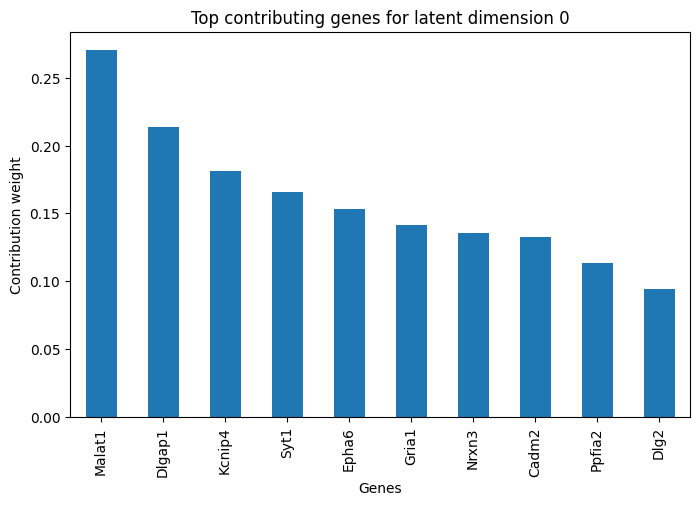

In [186]:
# Extract encoder weights
encoder_weights = autoencoder.encoder.weight.detach().numpy()
# Create a DataFrame for easier plotting
df = pd.DataFrame(encoder_weights.T, index=adata.var_names)
# Plot top contributing genes for a specific latent unit
latent_dim = 0  # Change this to visualize different latent dimensions
top_genes = df.iloc[:, latent_dim].sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 5))
top_genes.plot(kind='bar')
plt.xlabel('Genes')
plt.ylabel('Contribution weight')
plt.title(f'Top contributing genes for latent dimension {latent_dim}')
plt.show()

# Latent dimensions heatmap

In [144]:
def plot_latent_heatmap(autoencoder, data, adata, sample_tags=None):
    """
    Plots a heatmap of latent activations, optionally displaying only specific sample tags.
    
    Parameters:
    - autoencoder: Trained autoencoder model.
    - data: Input data to be encoded.
    - adata: AnnData object containing the observations.
    - sample_tags: List of specific sample tags to display. If None, displays all.
    """
    # Encode the data to get latent representations
    latents, _ = autoencoder.encode(data)
    latents_np = latents.detach().cpu().numpy()
    sample_tags_all = adata.obs['Sample_Tag']
    # Filter sample tags if provided
    if sample_tags:
        mask_sample_tags = sample_tags_all.isin(sample_tags)
        latents_np = latents_np[mask_sample_tags]
        
    for i in range(10):
        print(f'Mean value for latent dimension {i} {np.mean(latents_np.T[i])}')
    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(latents_np, cmap='viridis', yticklabels=False)
    plt.xlabel('Latent dimensions')
    plt.ylabel('Cells')
    plt.title('Heatmap of latent activations')
    plt.show()

Mean value for latent dimension 0 19.51474952697754
Mean value for latent dimension 1 18.900907516479492
Mean value for latent dimension 2 35.90681457519531
Mean value for latent dimension 3 22.05755615234375
Mean value for latent dimension 4 23.264711380004883
Mean value for latent dimension 5 21.665328979492188
Mean value for latent dimension 6 31.46023941040039
Mean value for latent dimension 7 24.402446746826172
Mean value for latent dimension 8 79.51355743408203
Mean value for latent dimension 9 57.7737922668457


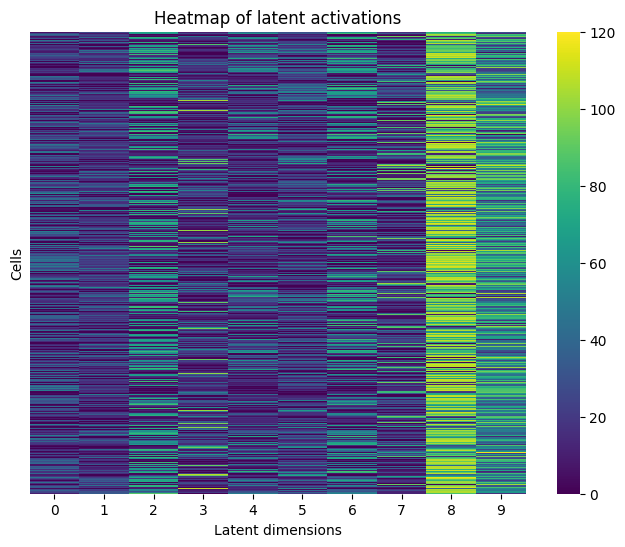

In [145]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['LD_5xFAD'])

Mean value for latent dimension 0 19.657489776611328
Mean value for latent dimension 1 19.137849807739258
Mean value for latent dimension 2 37.83041000366211
Mean value for latent dimension 3 17.350971221923828
Mean value for latent dimension 4 25.583524703979492
Mean value for latent dimension 5 23.022794723510742
Mean value for latent dimension 6 34.373138427734375
Mean value for latent dimension 7 26.397275924682617
Mean value for latent dimension 8 78.69342803955078
Mean value for latent dimension 9 58.23573684692383


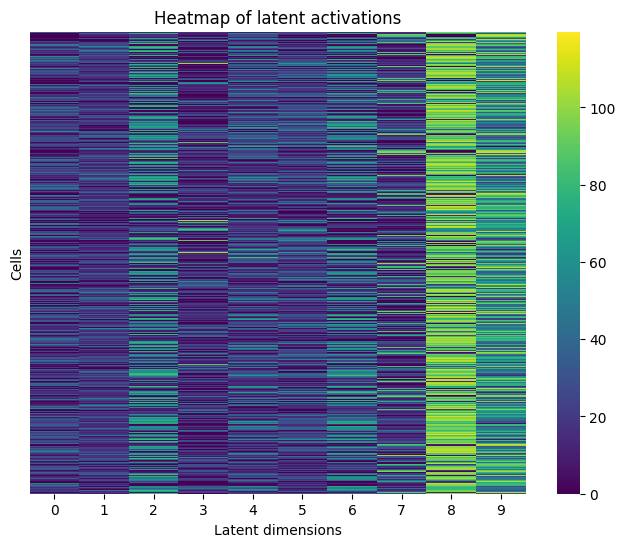

In [146]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=["LD_NC"])

Mean value for latent dimension 0 23.60602378845215
Mean value for latent dimension 1 20.66985321044922
Mean value for latent dimension 2 33.4695930480957
Mean value for latent dimension 3 23.97988510131836
Mean value for latent dimension 4 21.92824935913086
Mean value for latent dimension 5 21.317537307739258
Mean value for latent dimension 6 30.94277000427246
Mean value for latent dimension 7 22.803775787353516
Mean value for latent dimension 8 83.34941864013672
Mean value for latent dimension 9 58.85171890258789


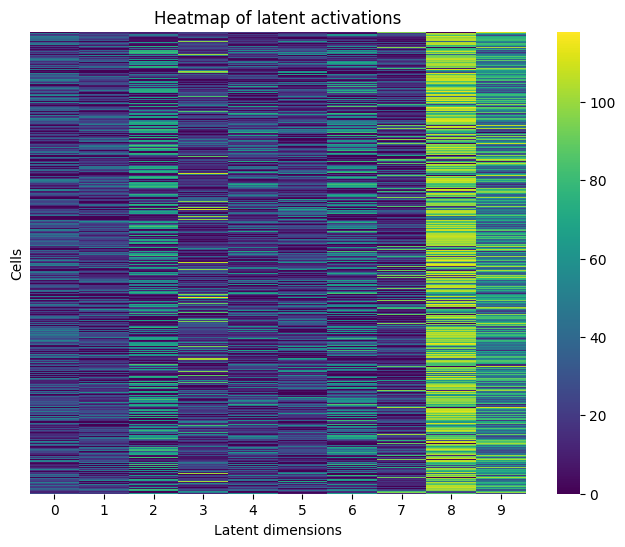

In [147]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=["run_5xFAD"])

Mean value for latent dimension 0 19.865097045898438
Mean value for latent dimension 1 18.30579376220703
Mean value for latent dimension 2 34.90728759765625
Mean value for latent dimension 3 18.141530990600586
Mean value for latent dimension 4 25.113300323486328
Mean value for latent dimension 5 23.082326889038086
Mean value for latent dimension 6 31.95663070678711
Mean value for latent dimension 7 23.513046264648438
Mean value for latent dimension 8 79.39779663085938
Mean value for latent dimension 9 59.303287506103516


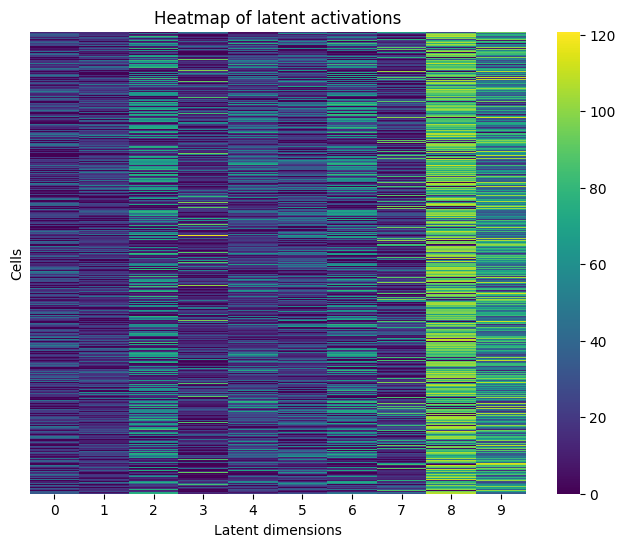

In [148]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['run_NC'])

# Visualize embedding

In [89]:
def plot_umap_embedding(embedding, adata, sample_tags=None, min_count=100):
    """
    Plots UMAP embedding, optionally displaying only specific sample tags.
    The legend will always display cell types.
    Parameters:
    - embedding: numpy array of UMAP embeddings.
    - adata: AnnData object containing the observations.
    - sample_tags: List of specific sample tags to display. If None, displays all.
    - min_count: Minimum number of observations for a cell type to be displayed.
    """
    cell_types = adata.obs['class_name']
    sample_tags_all = adata.obs['Sample_Tag']
    # Filter cell types by min_count
    cell_type_counts = cell_types.value_counts()
    valid_cell_types = cell_type_counts[cell_type_counts >= min_count].index
    mask_cell_types = cell_types.isin(valid_cell_types)
    filtered_embedding = embedding[mask_cell_types]
    filtered_cell_types = cell_types[mask_cell_types]
    filtered_sample_tags = sample_tags_all[mask_cell_types]
    # Filter sample tags if provided
    if sample_tags:
        mask_sample_tags = filtered_sample_tags.isin(sample_tags)
        final_embedding = filtered_embedding[mask_sample_tags]
        final_cell_types = filtered_cell_types[mask_sample_tags]
    else:
        final_embedding = filtered_embedding
        final_cell_types = filtered_cell_types
    # Create a consistent color palette
    unique_cell_types = valid_cell_types
    palette = sns.color_palette('tab10', len(unique_cell_types))
    color_dict = {cell_type: palette[i] for i, cell_type in enumerate(unique_cell_types)}
    # Plot UMAP embedding
    plt.figure(figsize=(6, 4))
    scatter = sns.scatterplot(x=final_embedding[:, 0], y=final_embedding[:, 1], hue=final_cell_types, palette=color_dict, s=5)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP of latent representations')
    # Adjust legend to be outside the plot
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
    plt.tight_layout()
    plt.show()

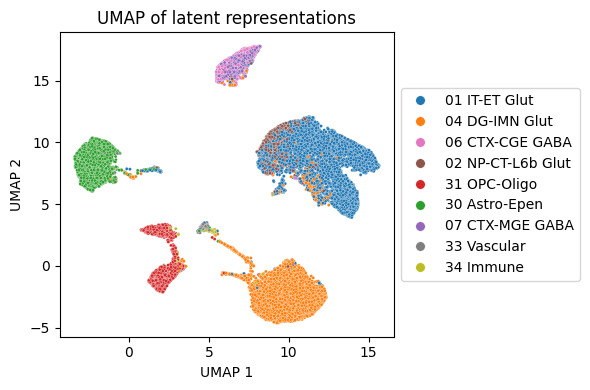

In [91]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_NC', 'LD_5xFAD', 'run_5xFAD', 'run_NC'], min_count=100)

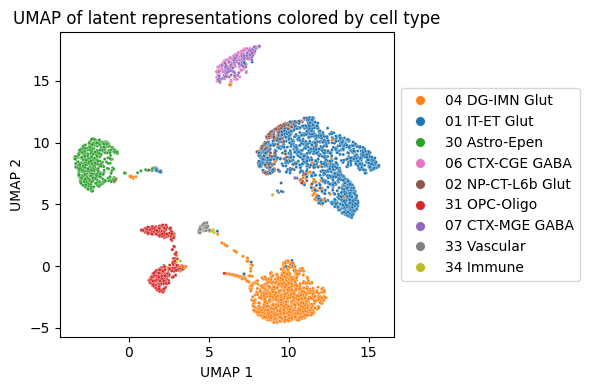

In [88]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_5xFAD'], min_count=100)

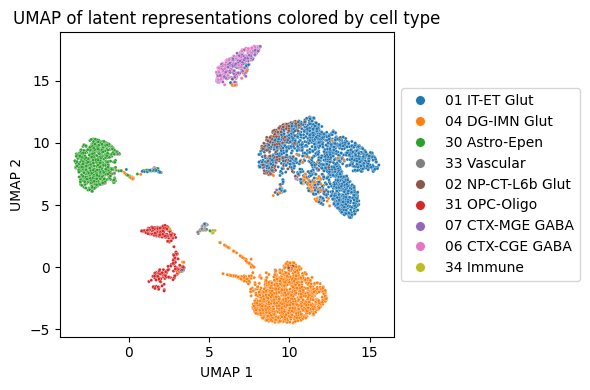

In [86]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_NC'], min_count=100)

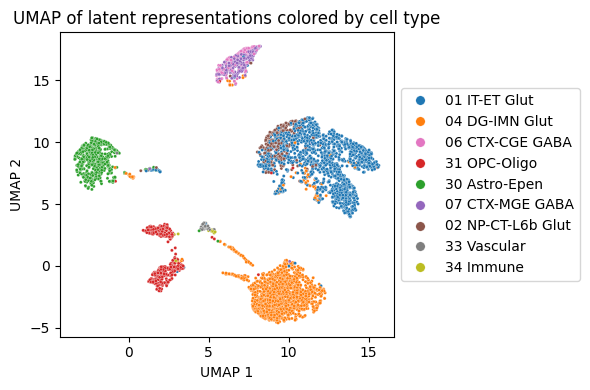

In [82]:
plot_umap_embedding(embedding, adata_test, sample_tags=['run_NC'], min_count=100)

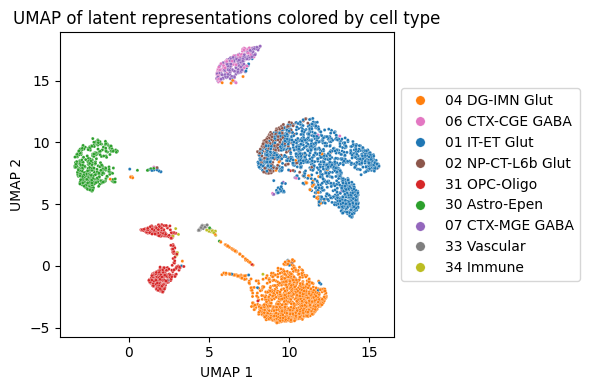

In [84]:
plot_umap_embedding(embedding, adata_test, sample_tags=['run_5xFAD'], min_count=100)

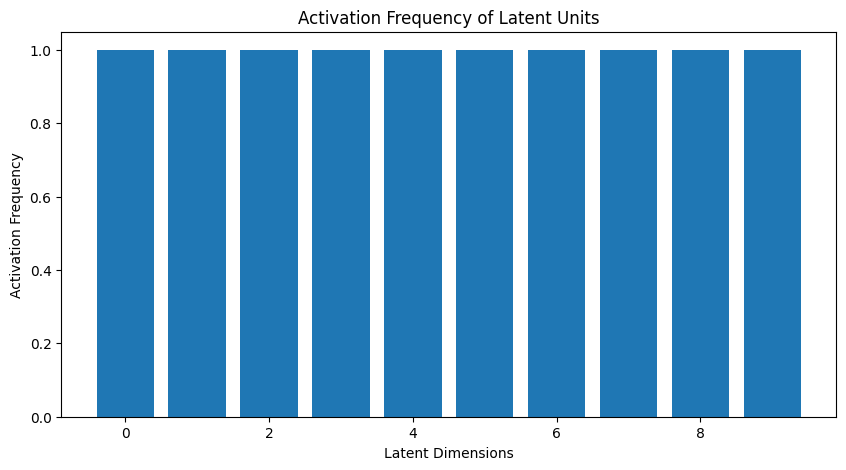

In [187]:
def plot_activation_frequency(autoencoder: nn.Module) -> None:
    """
    Plots the activation frequency of latent units in the autoencoder.

    :param autoencoder: The trained autoencoder model
    """
    # Get the activation frequency from the model
    activation_freq = autoencoder.latents_activation_frequency.detach().numpy()

    # Plot the activation frequency
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(activation_freq)), activation_freq)
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Activation Frequency')
    plt.title('Activation Frequency of Latent Units')
    plt.show()

# Example usage
plot_activation_frequency(autoencoder)

# Plot reconstructions

In [188]:
def plot_cell_reconstruction(autoencoder, data, cell_idx=0):
    """
    Plots original vs. reconstructed data for a specific cell.
    
    Parameters:
    - autoencoder: Trained autoencoder model.
    - data: Input data to be encoded.
    - cell_idx: Index of the cell to visualize. Default is 0.
    """
    # Get reconstructed data
    _, _, recons = autoencoder(data)

    # Convert to NumPy arrays for visualization
    original_data = data.numpy()
    reconstructed_data = recons.detach().numpy()

    # Plot original vs. reconstructed data for the specified cell
    plt.figure(figsize=(10, 5))
    plt.plot(original_data[cell_idx, :], label='Original')
    plt.plot(reconstructed_data[cell_idx, :], label='Reconstructed')
    plt.xlabel('Genes')
    plt.ylabel('Expression Level')
    plt.title(f'Original vs. reconstructed data for cell {cell_idx}')
    plt.legend()
    plt.show()

def plot_gene_reconstruction(autoencoder, data, gene_idx=0):
    """
    Plots original vs. reconstructed data for a specific gene.
    
    Parameters:
    - autoencoder: Trained autoencoder model.
    - data: Input data to be encoded.
    - gene_idx: Index of the gene to visualize. Default is 0.
    """
    # Get reconstructed data
    _, _, recons = autoencoder(data)

    # Convert to NumPy arrays for visualization
    original_data = data.numpy()
    reconstructed_data = recons.detach().numpy()

    # Plot original vs. reconstructed data for the specified gene
    plt.figure(figsize=(10, 5))
    plt.plot(original_data[:, gene_idx], label='Original')
    plt.plot(reconstructed_data[:, gene_idx], label='Reconstructed')
    plt.xlabel('Cells')
    plt.ylabel('Expression Level')
    plt.title(f'Original vs. reconstructed data for gene {gene_idx}')
    plt.legend()
    plt.show()

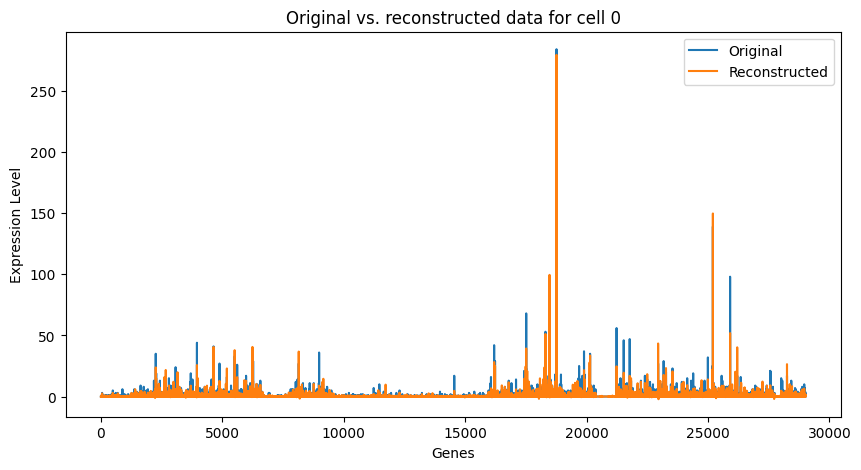

In [189]:
plot_cell_reconstruction(autoencoder, data, cell_idx=0)

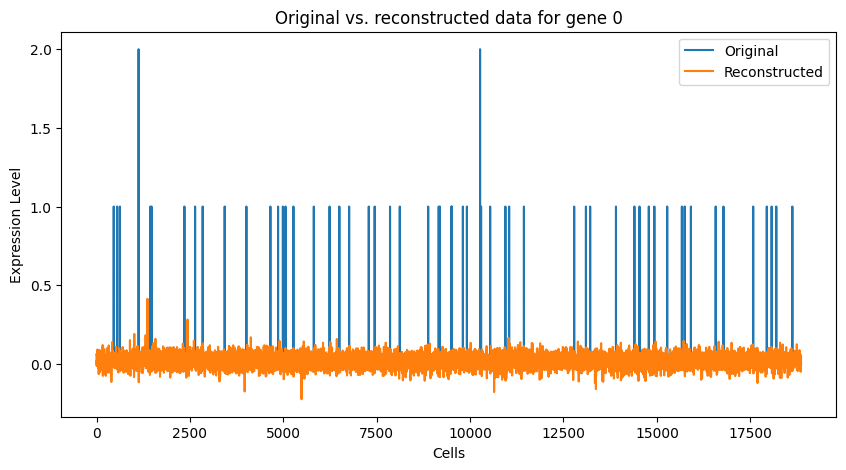

In [190]:
plot_gene_reconstruction(autoencoder, data, gene_idx=0)